In [12]:
from tensorflow.keras.models import load_model
###### AE MODEL LOAD ######
ae_wo_classifier = load_model('model/AE_model/KERAS_check_best_model.h5')
ae_wo_classifier_pruned = load_model('model/AE_model/KERAS_check_pruned_best_model.h5')
ae_w_classifier = load_model('model/AE_model/KERAS_check_best_model_classifier.h5')
ae_w_classifier_pruned = load_model('model/AE_model/KERAS_check_pruned_best_model_classifier.h5')

In [13]:
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects
co = {}
_add_supported_quantized_objects(co)

qae_wo_classifier = load_model('model/QAE_model/KERAS_check_best_model.h5', custom_objects=co)
qae_wo_classifier_pruned = load_model('model/QAE_model/KERAS_check_pruned_best_model.h5', custom_objects=co)
qae_w_classifier = load_model('model/QAE_model/KERAS_check_best_model_classifier.h5', custom_objects=co)
qae_w_classifier_pruned = load_model('model/QAE_model/KERAS_check_pruned_best_model_classifier.h5', custom_objects=co)

## Check sparsity
Make a quick check that the model was indeed trained sparse. We'll just make a histogram of the weights of the 1st layer, and hopefully observe a large peak in the bin containing '0'. Note logarithmic y axis.

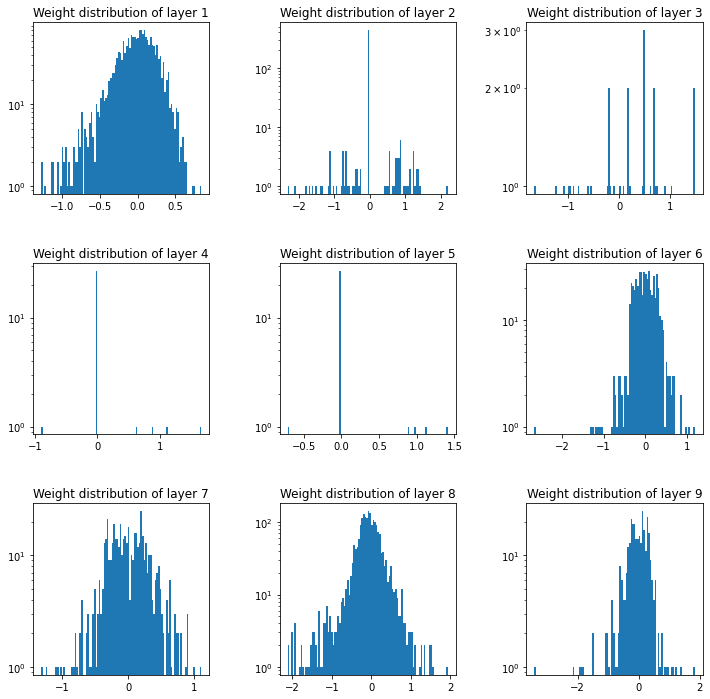

In [24]:
import numpy as np
import matplotlib.pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(12, 12))
columns = 3
rows = 3
fig.subplots_adjust(hspace=0.4, wspace=0.4)

#this applies for the quantized loop
num_layers = [1,3,5,6,7,10,11,14,15]
j = 1

#for i in num_layers:
for i in range(1, columns*rows +1):  
    fig.add_subplot(rows, columns, j)
    w = ae_w_classifier_pruned.layers[i].weights[0].numpy()
    h, b = np.histogram(w, bins=100)
    plt.bar(b[:-1], h, width=b[1]-b[0])
    plt.semilogy()
    plt.title('Weight distribution of layer '+ str(j))
    j+=1

#plt.savefig('./Report/images/section4/pruned_weightsdistr.png')
plt.show()


# Make an hls4ml config & model

In [21]:
import plotting
import hls4ml
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

config = hls4ml.utils.config_from_keras_model(qae_w_classifier_pruned, granularity='name')
config['LayerName']['classifier_output']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['classifier_output']['inv_table_t'] = 'ap_fixed<18,4>'
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(qae_w_classifier_pruned,
                                                       hls_config=config,
                                                       output_dir='model/QAE_model/hls4ml_prj',
                                                       part='xcu250-figd2104-2L-e')
                                                       #part='xcvu9p-flgc2104aaz')
                                                       #part='xc7vx690t-ffg176-2')


Interpreting Model
Topology:
Layer name: encoder_input, layer type: Input
Layer name: fc1, layer type: QDense
Layer name: relu1, layer type: QActivation
Layer name: fc2_prun, layer type: QDense
Layer name: relu2, layer type: QActivation
Layer name: encoder_output, layer type: Dense
  -> Activation (relu), layer name: encoder_output
Layer name: fc3, layer type: QDense
Layer name: fc4_prunedclass, layer type: QDense
Layer name: relu3, layer type: QActivation
Layer name: prunclass_relu4, layer type: QActivation
Layer name: fc4, layer type: QDense
Layer name: fc5_class, layer type: QDense
Layer name: relu4, layer type: QActivation
Layer name: class_relu5, layer type: QActivation
Layer name: decoder_output, layer type: QDense
Layer name: classifier_out, layer type: QDense
Layer name: sigmoid, layer type: Activation
Layer name: classifier_output, layer type: Activation
-----------------------------------
Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
  Strategy:          La

# Compile

In [22]:
hls_model.compile()

Writing HLS project
Done


Exception: Failed to compile project "myproject"

# Build

In [23]:
hls_model.build(csim=False)

Project myproject_prj does not exist. Rerun "hls4ml build -p model/QAE_model/hls4ml_prj".
